In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PriorVAE: Comparisons of scaling

In [10]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as onp
from jax import random
from numpyro.infer import Predictive

from plotting.helpers import pretty_label, pretty_loss_fn_name
from plotting.plots import (plot_draws_hpdi, plot_graph_times,
                            plot_matrix_time, plot_training, plot_score_contours)
from reusable.gp import OneDGP
from reusable.util import (gen_file_name, get_decoder_params, load_args,
                           load_scores, load_training_history,
                           load_training_state, update_args_11)
from reusable.vae import VAE, vae_sample
from plotting.consts import *
from matplotlib.transforms import Bbox

In [11]:
# def plot_experiment(experiment, count):
#     temp_args = load_args("11", count, experiment)


#     gp_draws = plot_gp_predictive(rng_key_gp, x=temp_args["x"], gp_kernel=temp_args["gp_kernel"], jitter=1e-5)["y"]

#     exp_args = temp_args[experiment]

#     aL = len(exp_args["Arange"])
#     bL = len(exp_args["Brange"])


#     for loss_fn in temp_args["loss_fns"]:
#         pretty_lf = pretty_loss_fn_name(loss_fn)

#         prettyAdesc = pretty_label(exp_args["Adesc"])
#         prettyBdesc = pretty_label(exp_args["Bdesc"])
        
#         training_fig = plt.figure

#         training_fig, training_axs = plt.subplots(nrows=aL, ncols=bL, figsize=(bL * 6, aL * 5))
#         training_fig.suptitle(
#             f"{experiment}: row:{prettyAdesc}, col:{prettyBdesc}Test/train for loss fn {pretty_lf}",
#             fontsize=40,
#         )

#         comp_fig, comp_axs = plt.subplots(nrows=aL + 1, ncols=bL, figsize=(bL * 6, aL * 5 + 5))
#         comp_fig.suptitle(
#             f"{experiment}: row:{prettyAdesc}, col:{prettyBdesc} comparison plots for {pretty_lf}",
#             fontsize=40,
#         )

#         plot_draws_hpdi(gp_draws, temp_args["x"], f"GP draws", "$y=f_{GP}(x)$", "GP", ax=comp_axs[0, 0])

#         for j in range(1, len(exp_args["Brange"])):
#             comp_axs[0, j].remove()

#         for i, a in enumerate(exp_args["Arange"]):
#             for j, b in enumerate(exp_args["Brange"]):
#                 args =  load_args("11", count, experiment)

#                 args = update_args_11(args, args[experiment], i, j)

#                 index = i + j * aL
#                 try:
#                     metrics_history = load_training_history("11", gen_file_name("11", args, f"11_{experiment}_{index}_{loss_fn}"))

                    
#                     plot_training(
#                         metrics_history["test_loss"],
#                         metrics_history["train_loss"],
#                         f"Test/train loss for {prettyAdesc}={a}, {prettyBdesc}={b}",
#                         "loss",
#                         training_axs[i, j],
#                     )

#                     dummy = VAE(
#                         hidden_dim1=args["hidden_dim1"],
#                         hidden_dim2=args["hidden_dim2"],
#                         latent_dim=args["latent_dim"],
#                         out_dim=args["n"],
#                         conditional=False,
#                     )
#                     dummy_params = dummy.init(random.PRNGKey(0), jnp.ones((args["latent_dim"],)))

#                     decoder_params = get_decoder_params(load_training_state("11", gen_file_name("11", args, f"11_{experiment}_{index}_{loss_fn}"), dummy_params))

                  
#                     plot_vae_predictive = Predictive(vae_sample, num_samples=1000)
#                     vae_draws = plot_vae_predictive(
#                         rng_key_predict,
#                         hidden_dim1=args["hidden_dim1"],
#                         hidden_dim2=args["hidden_dim2"],
#                         latent_dim=args["latent_dim"],
#                         out_dim=args["n"],
#                         decoder_params=decoder_params,
#                     )["f"]

#                     plot_draws_hpdi(
#                         vae_draws,
#                         args["x"],
#                         f"{prettyAdesc}={a}, {prettyBdesc}={b}",
#                         "$y=f_{VAE}(x)$",
#                         "VAE",
#                         ax=comp_axs[i + 1, j],
#                     )

#                 except FileNotFoundError:
#                     print(f"Failed to load a={a}, b={b}")

#         comp_fig.savefig(f"./gen_plots/11/exps/11_{experiment}_{count}_{loss_fn}_draws.pdf")
#         training_fig.savefig(f"./gen_plots/11/exps/11_{experiment}_{count}_{loss_fn}_training.pdf")


# Grid of training plots

In [12]:
def get_experiment_times(experiment, args_disambig, loss_fn_index):
    temp_args = load_args("11", args_disambig, experiment)


    exp_args = temp_args[experiment]

    loss_fn = temp_args["loss_fns"][loss_fn_index]


    histories = []


    for i, a in enumerate(exp_args["Arange"]):
        i_hists = []
        for j, b in enumerate(exp_args["Brange"]):
            args =  load_args("11", args_disambig, experiment)

            args = update_args_11(args, args[experiment], i, j)

            index = i + j * len(args[experiment]["Arange"])
        

            try:
                h = load_training_history("11", gen_file_name("11", args, f"11_{experiment}_{index}_{loss_fn}", "B"))
                i_hists.append(h)

            except FileNotFoundError:
                i_hists.append({"interrupted": True})
                print(f"Failed to load a={a}, b={b}")
        histories.append(i_hists)
        
    full_times = onp.array([[h["epoch_times"][-1] if "epoch_times" in h else float('nan') for h in hs] for hs in histories]) / 60

    interrupted = onp.array([["interrupted" in h for h in hs] for hs in histories])

    masked_times = onp.ma.array(full_times, mask=interrupted)

    return masked_times, exp_args, loss_fn

def plot_times_mat(experiment, masked_times, exp_args, loss_fn):
    pretty_lf = pretty_loss_fn_name(loss_fn)

    prettyAdesc = pretty_label(exp_args["Adesc"])
    prettyBdesc = pretty_label(exp_args["Bdesc"])

    # matrix of A x B, showing times
    plot_matrix_time(
        masked_times,
        exp_args["Arange"],
        exp_args["Brange"],
        prettyAdesc,
        prettyBdesc,
        f"{experiment}: {pretty_lf}",
        save_path=f"./gen_plots/11/times/11_{experiment}_{loss_fn}_matrix.png",
    )


def plot_times_graph(masked_times, exp_args, loss_fn, x_choice="A", relative=False, ax=None, save_path=None):
    pretty_lf = pretty_loss_fn_name(loss_fn)
    prettyAdesc = pretty_label(exp_args["Adesc"])
    prettyBdesc = pretty_label(exp_args["Bdesc"])

    data = masked_times.T if x_choice == "A" else masked_times
    if relative:
        initial_times = onp.array(data)[:, 0][:, jnp.newaxis]
        initial_times = jnp.tile(initial_times, (1, data.shape[1]))
        data = onp.ma.subtract(data, initial_times)
    else:
        data = masked_times


    plot_graph_times(
            data,
            exp_args["Arange"] if x_choice == "A" else exp_args["Brange"],
            exp_args["Brange"] if x_choice == "A" else exp_args["Arange"],
            prettyAdesc if x_choice == "A" else prettyBdesc,
            prettyBdesc if x_choice == "A" else prettyAdesc,
            f"{pretty_lf}",
            save_path=save_path, #f"./gen_plots/11/times/11_{experiment}_{loss_fn}_timeV{'a' if x_choice=='A' else 'b'}.png",
            is_relative=relative,
            ax=ax
        )



In [13]:
from plotting.plots import plot_scores_graph


def get_experiment_scores(experiment, args_disambig, loss_fn_index):
    temp_args = load_args("11", args_disambig, experiment)

    exp_args = temp_args[experiment]
    aL = len(exp_args["Arange"])

    loss_fn = temp_args["loss_fns"][loss_fn_index]

    scores = []

    for i, a in enumerate(exp_args["Arange"]):
        ss = []
        for j, b in enumerate(exp_args["Brange"]):
            args = load_args("11", args_disambig, experiment)

            args = update_args_11(args, args[experiment], i, j)

            index = i + j * aL

            try:
                s = load_scores("11", gen_file_name("11", args, f"11_{experiment}_{index}_{loss_fn}", "B"))
                new_s = {
                    "frobenius": jnp.mean(jnp.array(s["frobenius"])),
                    "moments_diff": jnp.mean(
                        jnp.abs(jnp.mean(jnp.array(s["vae_moments"]) - jnp.array(s["gp_moments"]), axis=1))
                    ),
                    "mmd": jnp.sum(jnp.array([x[1] for x in s["mmd"]])),
                }

                ss.append(new_s)

            except FileNotFoundError:
                ss.append({"frobenius": onp.nan, "moments_diff": onp.nan, "mmd": onp.nan, "interrupted": True})
                print(f"Failed to load a={a}, b={b}")
        scores.append(ss)

    to_return = ["frobenius", "moments_diff", "mmd"]

    interrupted = onp.array([["interrupted" in cell for cell in row] for row in scores])

    final_scores = {}
    for t in to_return:
        final_scores[t] = onp.array([[cell[t] for cell in row] for row in scores])

    return final_scores, interrupted, exp_args, loss_fn

# plot_times_matrix(
#     masked_scores,
#     exp_args["Arange"],
#     exp_args["Brange"],
#     prettyAdesc,
#     prettyBdesc,
#     f"{experiment}: {pretty_lf}, {t}",
#     save_path=f"./gen_plots/11/scores/11_{experiment}_{loss_fn}_{t}_matrix.png",
#     upper_limit=outlier_bounds[i] if outlier_bounds is not None else None
# )

# plot_score_contours(
#     masked_scores,
#     exp_args["Arange"],
#     exp_args["Brange"],
#     prettyAdesc,
#     prettyBdesc,
#     f"{experiment}: {pretty_lf}, {t}",
#     save_path=f"./gen_plots/11/scores/11_{experiment}_{loss_fn}_{t}_contours.png",
#     upper_limit=outlier_bounds[i] if outlier_bounds is not None else None
# )

to_plot = ["frobenius", "moments_diff", "mmd"]
nice_labels = {"frobenius":"Mean Frobenius norm", "moments_diff": "Mean moments difference", "mmd": "Mean MMD score"}


def plot_experiment_scores(scores, interrupted, exp_args, loss_fn, score, x_choice, ax=None, plot_ranges=None, save_path=None):
    prettyAdesc = pretty_label(exp_args["Adesc"])
    prettyBdesc = pretty_label(exp_args["Bdesc"])
  
    pretty_lf = pretty_loss_fn_name(loss_fn)

    masked_scores = onp.ma.array(scores[score], mask=interrupted)

    print(exp_args["Arange"] if x_choice == "A" else exp_args["Brange"],
        exp_args["Brange"] if x_choice == "A" else exp_args["Arange"],)
    plot_scores_graph(
        masked_scores.T if x_choice == "A" else masked_scores,
        exp_args["Arange"] if x_choice == "A" else exp_args["Brange"],
        exp_args["Brange"] if x_choice == "A" else exp_args["Arange"],
        prettyAdesc if x_choice == "A" else prettyBdesc,
        nice_labels[score],
        prettyBdesc if x_choice == "A" else prettyAdesc,
        f"{pretty_lf}",
        save_path=save_path, #f"./gen_plots/11/scores/11_{experiment}_{loss_fn}_{t}_score_V_{Adesc if x_choice == 'A' else Bdesc}.png",
        num_decimals=4 if score == "mmd" else 0,
        plot_range=plot_ranges,
        ax=ax
    )
 
     


Failed to load a=600, b=4000
Failed to load a=800, b=4000


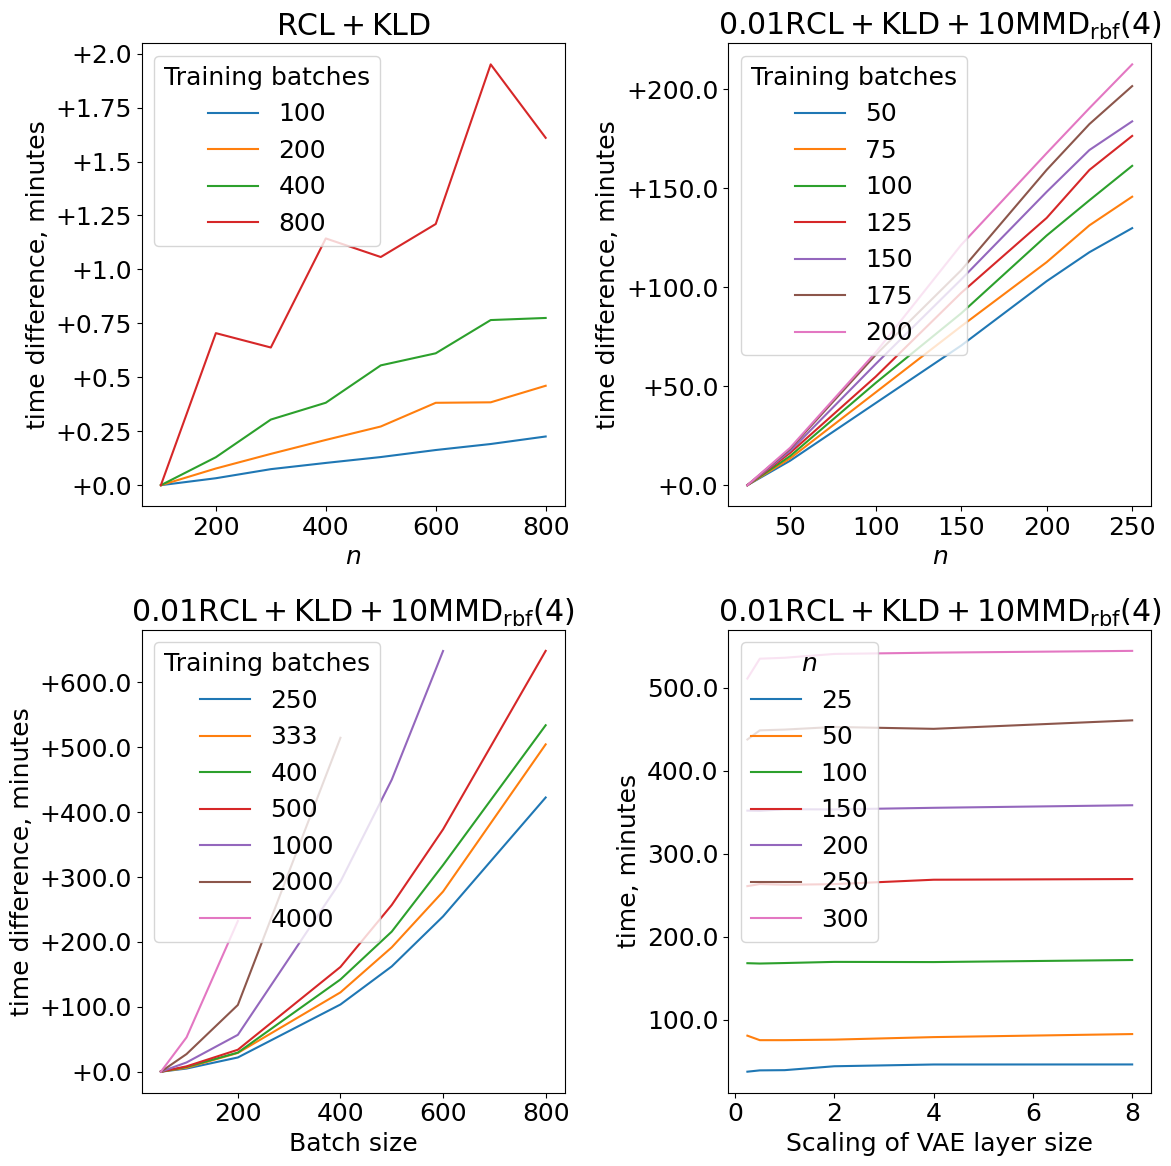

In [30]:
choices = [
    ("exp9", 1, 0, "A", True),
    ("exp5", 1, 1, "A", True),
    ("exp6", 1, 1, "A", True),
    ("exp8", 1, 1, "B", False),
]

fig = plt.figure()
fig.set_size_inches(PAGE_WIDTH, PAGE_WIDTH)

axs = fig.subplots(2, 2)

for i, c in enumerate(choices):
    times, args, loss_fn = get_experiment_times(*c[:3])
    plot_times_graph(times, args, loss_fn, c[3], c[4], axs.flat[i])

fig.tight_layout()

fig.savefig("./gen_plots/11/composites/compA.pdf")

# 1 -> 4 top lef
fig.savefig(
    "./gen_plots/11/composites/compA_topleft.pdf",
    bbox_inches=Bbox.from_bounds(0, PAGE_WIDTH // 2, PAGE_WIDTH // 2, PAGE_WIDTH // 2),
)
fig.savefig(
    "./gen_plots/11/composites/compA_topright.pdf",
    bbox_inches=Bbox.from_bounds(PAGE_WIDTH // 2, PAGE_WIDTH // 2, PAGE_WIDTH // 2, PAGE_WIDTH // 2),
)
fig.savefig(
    "./gen_plots/11/composites/compA_bottomleft.pdf",
    bbox_inches=Bbox.from_bounds(0, 0, PAGE_WIDTH // 2, PAGE_WIDTH // 2),
)
fig.savefig(
    "./gen_plots/11/composites/compA_bottomright.pdf",
    bbox_inches=Bbox.from_bounds(PAGE_WIDTH // 2, 0, PAGE_WIDTH // 2, PAGE_WIDTH // 2),
)


0
[25, 50, 100, 150, 200, 225, 250] [50, 75, 100, 125, 150, 175, 200]
$0.01\mathrm{RCL}+\mathrm{KLD}+10\mathrm{MMD}_\mathrm{rbf}(4)$ $n$ [0, 50]
1
[25, 50, 100, 150, 200, 225, 250] [50, 75, 100, 125, 150, 175, 200]
$\mathrm{RCL}+\mathrm{KLD}$ $n$ [0, 50]
2
[1, 5, 10, 25, 50, 100] [25, 50, 100, 150, 200, 250, 300]
$0.01\mathrm{RCL}+\mathrm{KLD}+10\mathrm{MMD}_\mathrm{rbf}(4)$ Epochs [0, 100]
3
[1, 5, 10, 25, 50, 100] [25, 50, 100, 150, 200, 250, 300]
$\mathrm{RCL}+\mathrm{KLD}$ Epochs [0, 100]


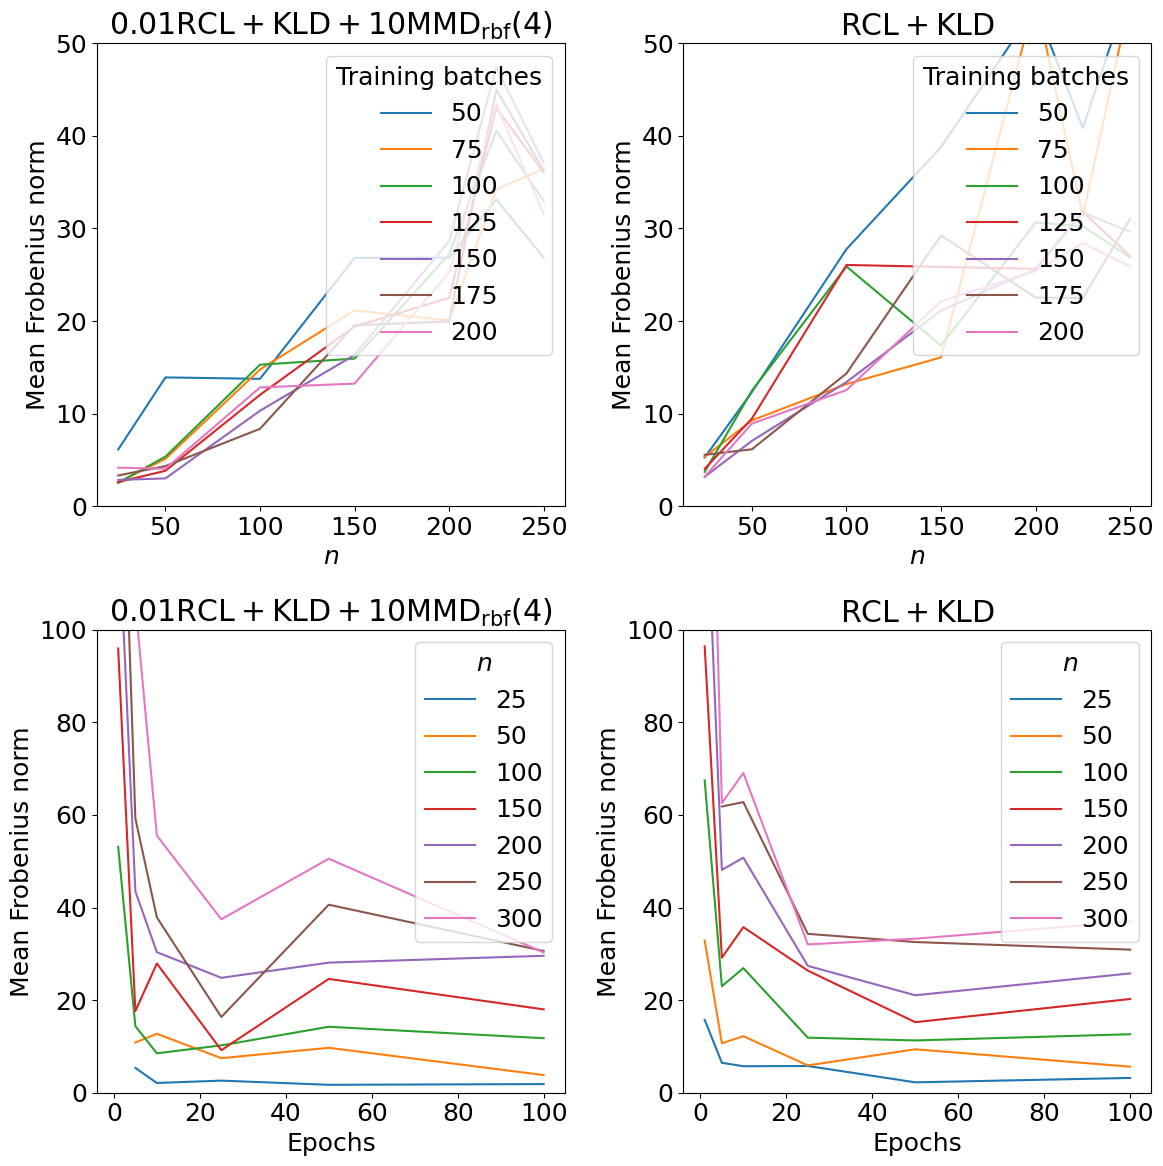

In [31]:
choices = [
    ("exp5", 1, 1, "frobenius", "A", [0,50]),
    ("exp5", 1, 0, "frobenius", "A", [0,50]),
    ("exp7", 1, 1, "frobenius", "B", [0,100]),
    ("exp7", 1, 0, "frobenius", "B", [0,100]),
]

fig = plt.figure()
fig.set_size_inches(PAGE_WIDTH, PAGE_WIDTH)

axs = fig.subplots(2, 2)

for i, c in enumerate(choices):
    times, mask, args, loss_fn = get_experiment_scores(*c[:3])
    print(i)
    plot_experiment_scores(times, mask, args, loss_fn, c[3], c[4], plot_ranges=c[5] if len(c)>5 else None, ax=axs.flat[i])

fig.tight_layout()

fig.savefig("./gen_plots/11/composites/compB.pdf")

# 1 -> 4 top lef
fig.savefig(
    "./gen_plots/11/composites/compB_topleft.pdf",
    bbox_inches=Bbox.from_bounds(0, PAGE_WIDTH // 2, PAGE_WIDTH // 2, PAGE_WIDTH // 2),
)
fig.savefig(
    "./gen_plots/11/composites/compB_topright.pdf",
    bbox_inches=Bbox.from_bounds(PAGE_WIDTH // 2, PAGE_WIDTH // 2, PAGE_WIDTH // 2, PAGE_WIDTH // 2),
)
fig.savefig(
    "./gen_plots/11/composites/compB_bottomleft.pdf",
    bbox_inches=Bbox.from_bounds(0, 0, PAGE_WIDTH // 2, PAGE_WIDTH // 2),
)
fig.savefig(
    "./gen_plots/11/composites/compB_bottomright.pdf",
    bbox_inches=Bbox.from_bounds(PAGE_WIDTH // 2, 0, PAGE_WIDTH // 2, PAGE_WIDTH // 2),
)


0
[0.25, 0.5, 1, 2, 4, 8] [25, 50, 100, 150, 200, 250, 300]
$\mathrm{RCL}+\mathrm{KLD}$ Scaling of VAE layer size [0, 93.7074737548828]


/home/max/mambaforge/envs/jax_numpyro_env/lib/python3.10/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


1
[0.25, 0.5, 1, 2, 4, 8] [25, 50, 100, 150, 200, 250, 300]
$\mathrm{RCL}+\mathrm{KLD}$ Scaling of VAE layer size [0, 34.26359481811523]
2
[0.25, 0.5, 1, 2, 4, 8] [25, 50, 100, 150, 200, 250, 300]
$\mathrm{RCL}+\mathrm{KLD}$ Scaling of VAE layer size [0, 3.3261743545532227]
3
[0.25, 0.5, 1, 2, 4, 8] [25, 50, 100, 150, 200, 250, 300]
$\mathrm{RCL}+\mathrm{KLD}$ Scaling of VAE layer size [0, 3.3261743545532227]


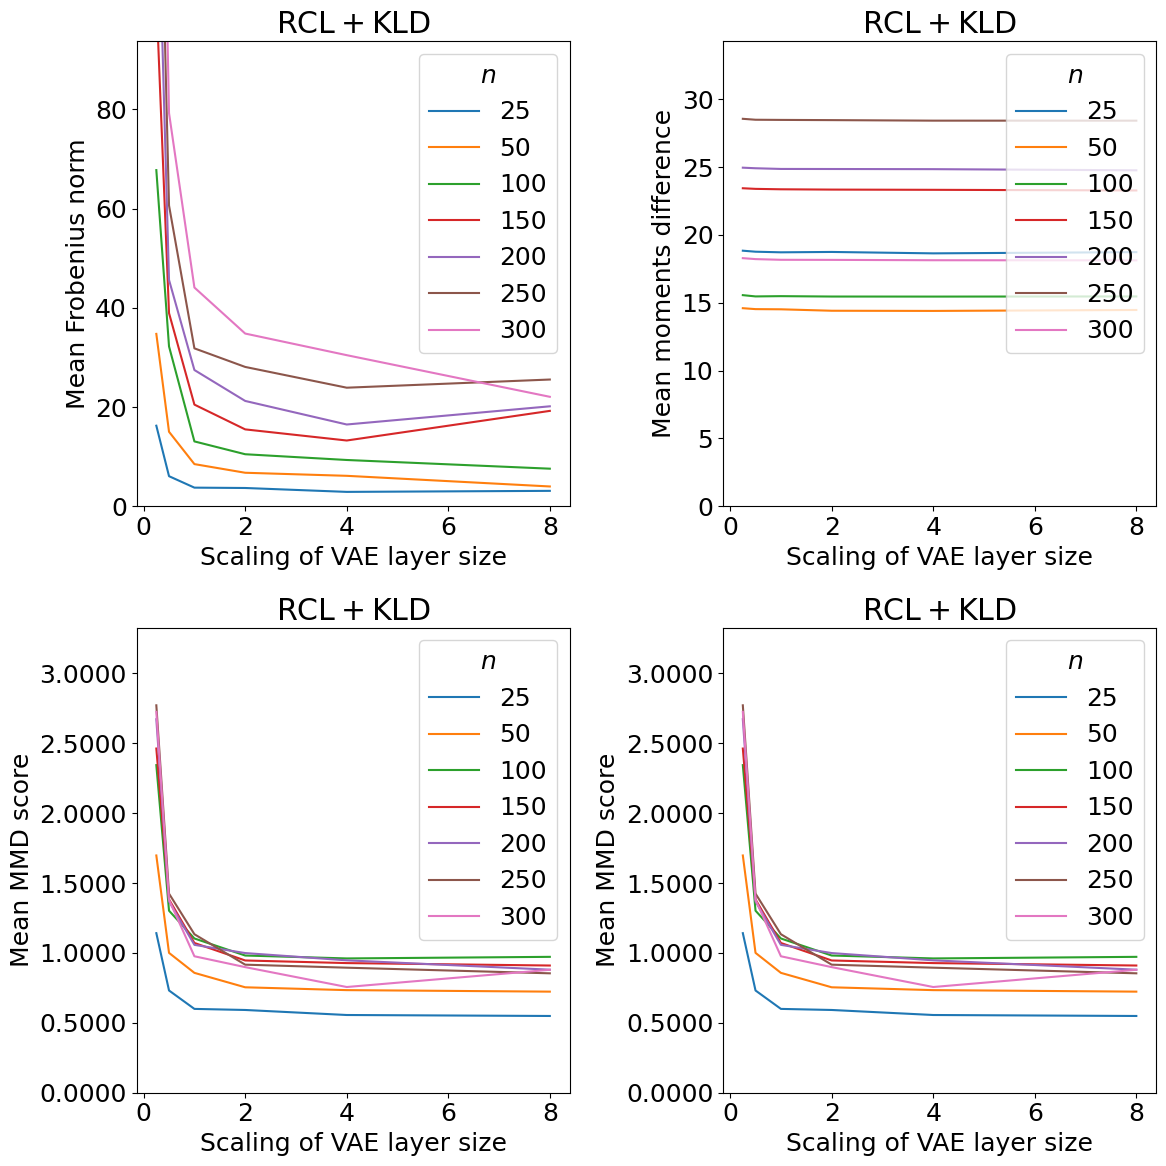

In [34]:
choices = [
    ("exp8", 1, 0, "frobenius", "B"),
    ("exp8", 1, 0, "moments_diff", "B"),
    ("exp8", 1, 0, "mmd", "B"),
     ("exp8", 1, 0, "mmd", "B"),
]

fig = plt.figure()
fig.set_size_inches(PAGE_WIDTH, PAGE_WIDTH)

axs = fig.subplots(2, 2)

for i, c in enumerate(choices):
    times, mask, args, loss_fn = get_experiment_scores(*c[:3])
    print(i)
    plot_experiment_scores(times, mask, args, loss_fn, c[3], c[4], plot_ranges=c[5] if len(c)>5 else None, ax=axs.flat[i])

fig.tight_layout()

fig.savefig("./gen_plots/11/composites/compC.pdf")


#.transformed((fig.transFigure - fig.dpi_scale_trans)),

# 1 -> 4 top lef
fig.savefig(
    "./gen_plots/11/composites/compC_topleft.pdf",
    bbox_inches=Bbox([[0, 0.5], [0.5, 1]]).transformed((fig.transFigure - fig.dpi_scale_trans)), # (0, PAGE_WIDTH // 2, PAGE_WIDTH // 2, PAGE_WIDTH // 2),
)
fig.savefig(
    "./gen_plots/11/composites/compC_topright.pdf",
    bbox_inches=Bbox.from_bounds(PAGE_WIDTH // 2, PAGE_WIDTH // 2, PAGE_WIDTH // 2, PAGE_WIDTH // 2),
)
fig.savefig(
    "./gen_plots/11/composites/compC_bottomleft.pdf",
    bbox_inches=Bbox.from_bounds(0, 0, PAGE_WIDTH // 2, PAGE_WIDTH // 2),
)
fig.savefig(
    "./gen_plots/11/composites/compC_bottomright.pdf",
    bbox_inches=Bbox.from_bounds(PAGE_WIDTH // 2, 0, PAGE_WIDTH // 2, PAGE_WIDTH // 2),
)


### Correlation for non-linear thing

Failed to load a=600, b=4000
Failed to load a=800, b=4000
x (7,)
y [1.6929455713159094 2.776120236390083 4.977664753977993 10.316329386861838
 12.850533615095847 15.562738974905468 20.627278125447948]
[[1.         0.99971629]
 [0.99971629 1.        ]]
x (7,)
y [1.8829162991140633 3.088063119457341 5.696934604106278 11.215840790391805
 13.972690066996167 16.76873272300017 22.540202076188596]
[[1.         0.99982685]
 [0.99982685 1.        ]]
x (7,)
y [1.8999399276070876 3.29731496373217 5.747059830553667 12.072517159768989
 14.816401890268715 17.94778033658805 23.18636705453228]
[[1.         0.99956689]
 [0.99956689 1.        ]]
x (7,)
y [2.1771363271685176 3.598452963266457 6.209161826885165 12.890613636358628
 16.176752988148866 19.44872649402997 25.560844485918953]
[[1.        0.9996584]
 [0.9996584 1.       ]]
x (7,)
y [2.953162891070846 4.793174723059994 8.09392746346631 17.36580804519329
 21.419158212723175 25.634722495003402 --]
[[1.         0.29644808]
 [0.29644808 1.        ]]


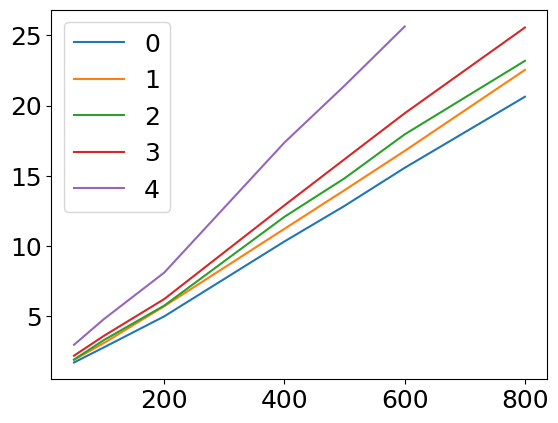

In [22]:
c =    ("exp6", 1, 1, "A", True)

import numpy
import matplotlib.pyplot as plt

times, args, loss_fn = get_experiment_times(*c[:3])


x = onp.power(args["Arange"],1)
ys = times.T

for i in range(5):
    y = onp.sqrt(ys[i])
    print("x", x.shape)
    print("y", y)
    print(numpy.corrcoef(x, y, rowvar=False))
    plt.plot(x,y, label=f"{i}")
    plt.legend()

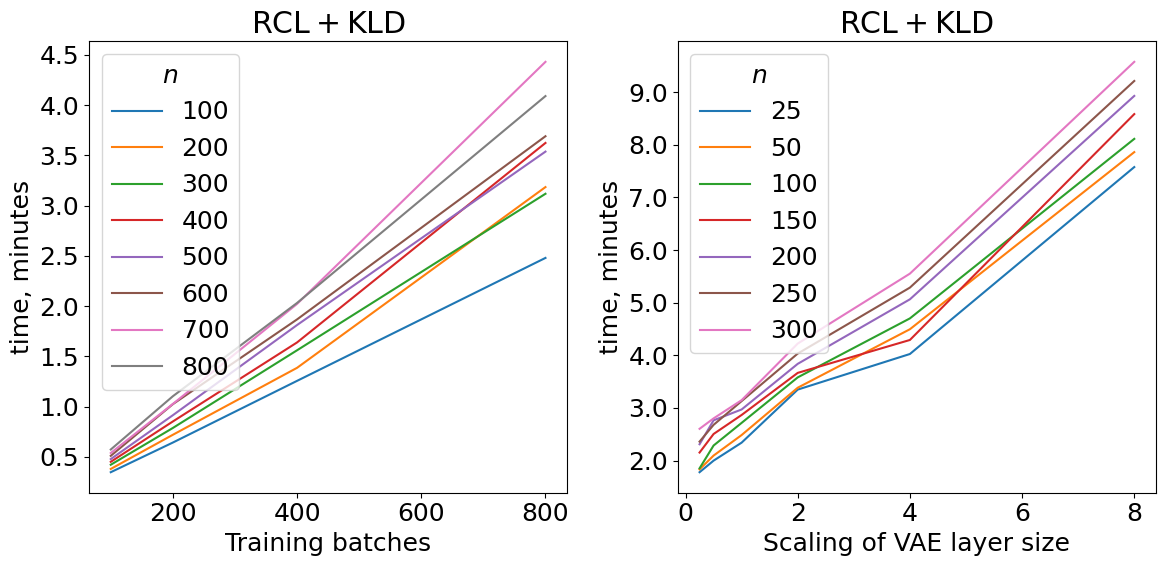

In [7]:
choices = [
    ("exp9", 1, 0, "B", False),
    ("exp8", 1, 0, "B", False),
]

fig = plt.figure()
fig.set_size_inches(PAGE_WIDTH, PAGE_WIDTH / 2)

axs = fig.subplots(1,2)

for i, c in enumerate(choices):
    times, args, loss_fn = get_experiment_times(*c[:3])
    plot_times_graph(times, args, loss_fn, c[3], c[4], axs.flat[i])

fig.tight_layout()

fig.savefig("./gen_plots/11/composites/compD.pdf")

# 1 -> 4 top lef
fig.savefig(
    "./gen_plots/11/composites/compD_left.pdf",
    bbox_inches=Bbox.from_bounds(0, 0, PAGE_WIDTH // 2, PAGE_WIDTH // 2),
)
fig.savefig(
    "./gen_plots/11/composites/compD_right.pdf",
    bbox_inches=Bbox.from_bounds(PAGE_WIDTH // 2,0, PAGE_WIDTH // 2, PAGE_WIDTH // 2),
)



[1, 5, 10, 25, 50, 100] [25, 50, 100, 150, 200, 250, 300]
$0.01\mathrm{RCL}+\mathrm{KLD}+10\mathrm{MMD}_\mathrm{rbf}(4)$ Epochs [0, 70]
[1, 5, 10, 25, 50, 100] [25, 50, 100, 150, 200, 250, 300]
$\mathrm{RCL}+\mathrm{KLD}$ Epochs [0, 70]
[1, 5, 10, 25, 50, 100] [25, 50, 100, 150, 200, 250, 300]
$0.01\mathrm{RCL}+\mathrm{KLD}+10\mathrm{MMD}_\mathrm{rbf}(4)$ Epochs [0, 2]
[1, 5, 10, 25, 50, 100] [25, 50, 100, 150, 200, 250, 300]
$\mathrm{RCL}+\mathrm{KLD}$ Epochs [0, 2]
[1, 5, 10, 25, 50, 100] [25, 50, 100, 150, 200, 250, 300]
$0.01\mathrm{RCL}+\mathrm{KLD}+10\mathrm{MMD}_\mathrm{rbf}(4)$ Epochs [0, 50]
[1, 5, 10, 25, 50, 100] [25, 50, 100, 150, 200, 250, 300]
$\mathrm{RCL}+\mathrm{KLD}$ Epochs [0, 50]


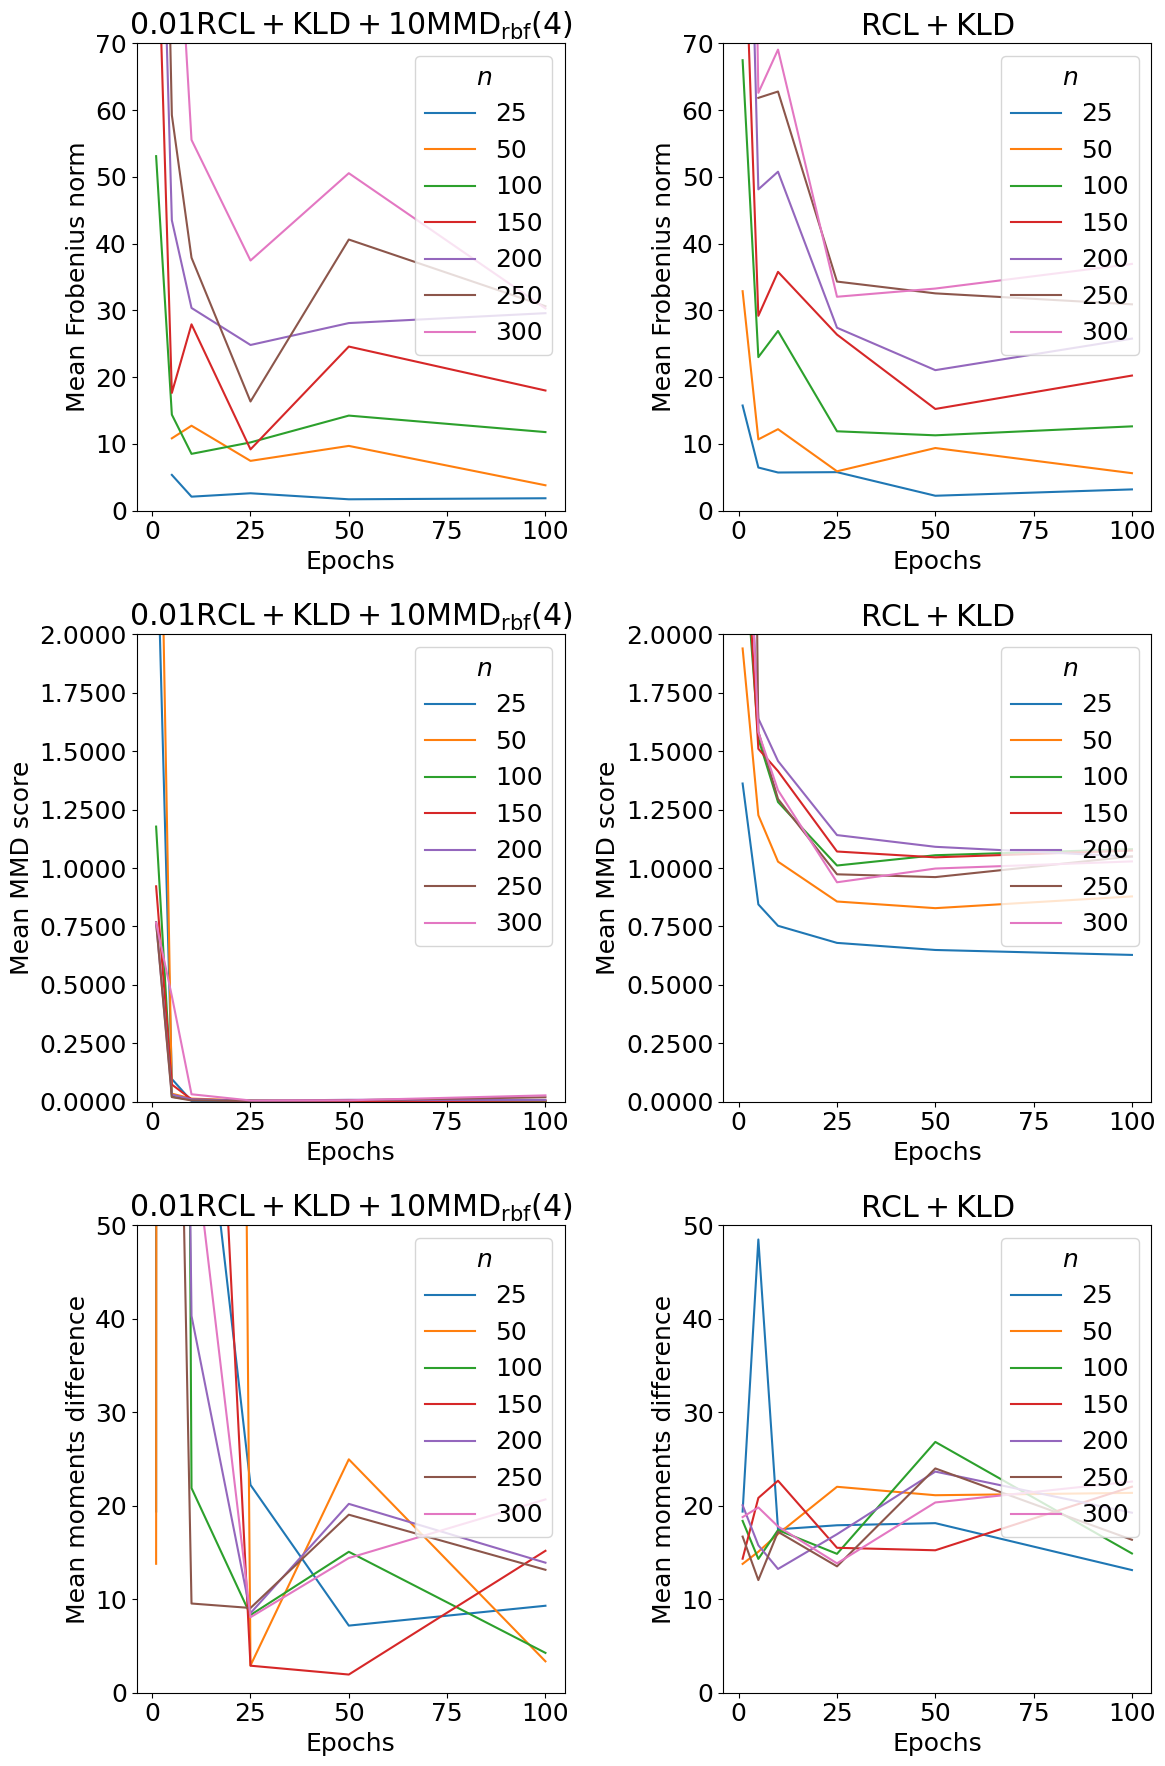

In [15]:
choices = [
    ("exp7", 1, 1, "frobenius", "B", [0,70]),
    ("exp7", 1, 0, "frobenius", "B", [0,70]),
    ("exp7", 1, 1, "mmd", "B", [0,2]),
    ("exp7", 1, 0, "mmd", "B", [0,2]),
    ("exp7", 1, 1, "moments_diff", "B", [0,50]),
    ("exp7", 1, 0, "moments_diff", "B", [0,50]),
]
fig = plt.figure()
fig.set_size_inches(PAGE_WIDTH, PAGE_HEIGHT)

axs = fig.subplots(3,2)

for i, c in enumerate(choices):
    times, mask, args, loss_fn = get_experiment_scores(*c[:3])
    plot_experiment_scores(times, mask, args, loss_fn, c[3], c[4], plot_ranges=c[5] if len(c)>5 else None, ax=axs.flat[i])


fig.tight_layout()

fig.savefig("./gen_plots/11/composites/compE.pdf")



